In [1]:
import equinox as eq
import jax
import jax.numpy as jnp
import numpy as np
import dynamiqs as dq
jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_enable_x64", True)


class Displacer(eq.Module):
    evals: jnp.ndarray
    evecs: jnp.ndarray
    range: jnp.ndarray
    t_scale: jnp.ndarray
    a: jnp.ndarray
    def __init__(self, n):
        # The off-diagonal of the real-symmetric similar matrix T.
        sym = (2*(jnp.arange(1, n)%2) - 1) * jnp.sqrt(jnp.arange(1, n))
        # Solve the eigensystem.
        
        # construct a tri-diagonal matrix
        _mat = jnp.diag(sym, 1) + jnp.diag(sym, -1)

        self.evals, self.evecs = jax.scipy.linalg.eigh(_mat)
        self.range = np.arange(n)
        self.t_scale = 1j**(self.range % 2)

        self.a = dq.destroy(n).to_jax()

    @jax.jit
    def new_method(self, alpha):
        # Diagonal of the transformation matrix P, and apply to eigenvectors.
        r, theta = jnp.abs(alpha), jnp.angle(alpha)
        transform = self.t_scale * (jnp.exp(1j*theta))**-self.range
        evecs = transform[:, None] * self.evecs
        # Get the exponentiated diagonal.
        diag = jnp.exp(1j * r * self.evals)
        return jnp.conj(evecs) @ (diag[:, None] * evecs.T)
    
    @jax.jit
    def old_method(self, alpha_single):
        return jax.scipy.linalg.expm(alpha_single * self.a.conj().T - alpha_single.conj() * self.a)

In [2]:
d = Displacer(50)

k = 512
alpha = jnp.array(np.random.uniform(0, 1, k) + 1j * np.random.uniform(0, 1, k))

# jnp.allclose(d.new_method(alpha), d.old_method(alpha))
# warmup
a = jax.vmap(d.new_method)(alpha)
b = jax.vmap(d.old_method)(alpha)

%timeit jax.vmap(d.new_method)(alpha)
%timeit jax.vmap(d.old_method)(alpha)

import timeit
from tqdm import tqdm
k = 512 

t1 = timeit.Timer("jax.vmap(d.new_method)(alpha)", globals=globals())
t2 = timeit.Timer("jax.vmap(d.old_method)(alpha)", globals=globals())


t_new_res = []
t_old_res = []
N_list = list(range(10, 101, 10))

928 μs ± 1.45 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
27 ms ± 5.47 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
from tqdm import tqdm
N_list = list(range(10, 101, 10))
for _N in tqdm(N_list):
    d = Displacer(_N)
    alpha = jnp.array(np.random.uniform(0, 1, k) + 1j * np.random.uniform(0, 1, k))
    # print(f"N = {_N}")

    # warmup
    jax.vmap(d.new_method)(alpha)
    jax.vmap(d.old_method)(alpha)
    new_time = t1.autorange()
    old_time = t2.autorange()
    t_new_res.append(new_time[1] / new_time[0])
    t_old_res.append(old_time[1] / old_time[0])
    # print()

100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


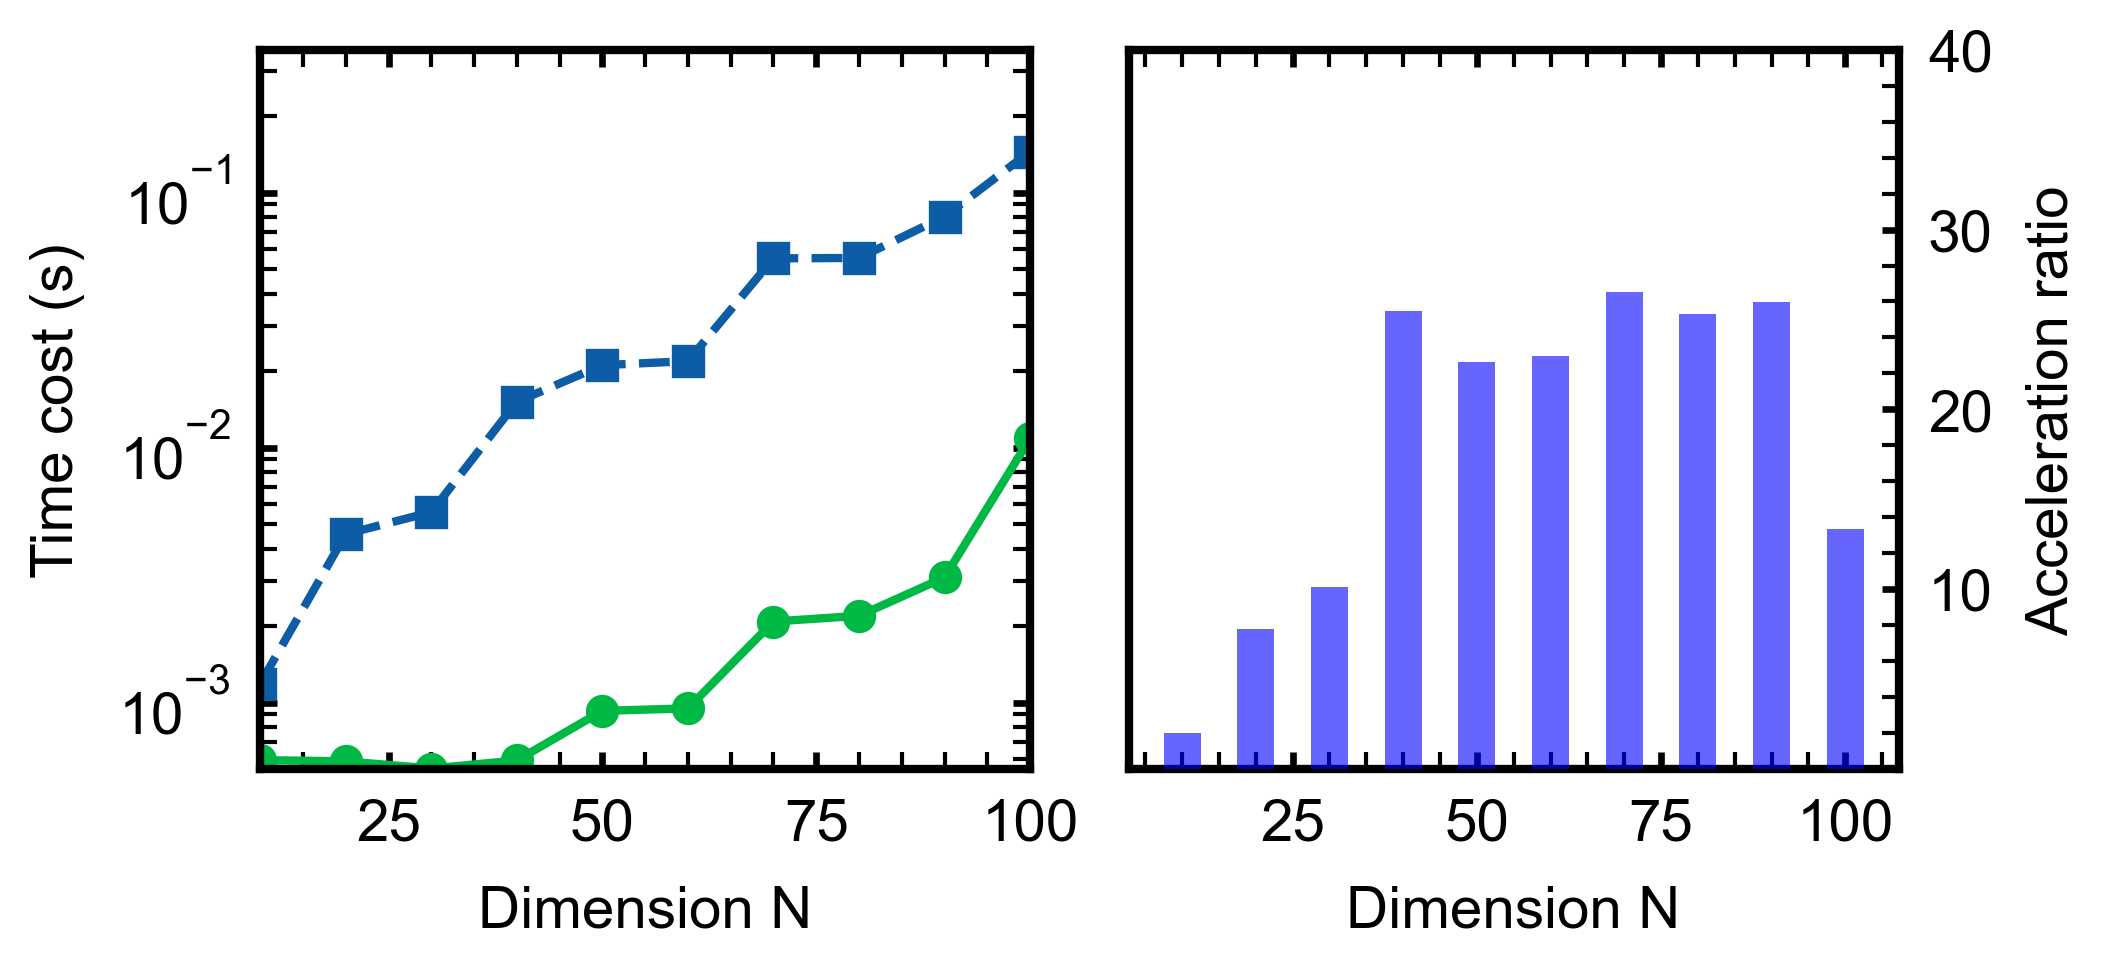

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
# use backend matplotlib
mpl.use('inline')
# plt.style.use(['science','nature'])
# plt.style.use(['science','nature'])

# 示例数据（请替换为你的实际数据）
# t_new_res = [/* your data */]
# t_old_res = [/* your data */]
# 这里假设 t_new_res 和 t_old_res 已经定义

# 设置整体样式
plt.style.use(["science", "nature"])

_tick_major_size = 4
_tick_minor_size = 3
_tick_width = 0.75
fontsize = 10
plt.rcParams.update(
    {
        "font.size": fontsize,
        # "legend.fontsize": fontsize,
        # "xtick.labelsize": fontsize,
        # "ytick.labelsize": fontsize,
        "font.family": ["Arial"],
        'axes.linewidth': 1,
        'xtick.major.size': _tick_major_size,
        'xtick.minor.size': _tick_minor_size,
        'xtick.major.width':_tick_width,
        'xtick.minor.width':_tick_width,
        'ytick.major.size': _tick_major_size,
        'ytick.minor.size': _tick_minor_size,
        'ytick.major.width':_tick_width,
        'ytick.minor.width':_tick_width,
        'text.usetex':False
        # 'font.family' : "Arial"

    }
)

fig, ax = plt.subplots(1,2,figsize=(3.5,1.6), constrained_layout=True, dpi=600)
plt.rcParams['text.usetex'] = False
# 左侧 y 轴，绘制线图
x = N_list
# ax[0].semilogy(x, t_old_res, label="Padé approximation",  marker='s', linestyle='--', zorder=2)
# ax[0].semilogy(x, t_new_res, label="EDOC",  marker='o', linestyle='-', zorder=2)

ax[0].semilogy(x, t_old_res, marker='s', linestyle='--', zorder=2)
ax[0].semilogy(x, t_new_res, marker='o', linestyle='-', zorder=2)

ax[0].set_xlabel('Dimension N')
ax[0].set_ylabel('Time cost (s)')
ax[0].tick_params(axis='y')

# 自动缩放 + 再手动扩大 y 轴上限
ax[0].autoscale(enable=True, tight=True)
ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax * 2.5)  # 向上扩展 20%

# ax1.legend(loc='upper left')
# ax[0].autoscale(enable=True, tight=True)

# 创建右侧的 y 轴，绘制条形图
# ax[1] = ax1.twinx()  # 共享 x 轴
bar_data = [x / y for x, y in zip(t_old_res, t_new_res)]
ax[1].bar(x, bar_data, alpha=0.6, label='Acceleration ratio',  width=5, color='blue', zorder=3)

# 设置 y 轴标签显示在右边
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylabel('Acceleration ratio')

# 设置 x 轴标签和刻度
ax[1].set_xlabel('Dimension N')
ax[1].set_xticks([25, 50, 75, 100])
ax[1].set_yticks([10,20,30,40])
# 可选：优化 y 轴样式（如果需要）
ax[1].tick_params(axis='y')
# 添加网格线，仅针对左侧 y 轴
# ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')
ax[0].set_zorder(1)  # 确保线图在条形图的上方/
# ax[0].patch.set_visible(False)  # 隐藏左侧 y 轴的边框


# 添加图例，避免重复
lines_1, labels_1 = ax[0].get_legend_handles_labels()
lines_2, labels_2 = ax[0].get_legend_handles_labels()
# leg = ax[0].legend(labels_1 + labels_2, loc='upper left', frameon=True, facecolor='white', edgecolor='black')
leg = ax[0].legend(
    labels_1 + labels_2,
    loc='upper left',
    fontsize=5.5,
    # bbox_to_anchor=(-0.04, 1.0)  # 向左移一些
)

# 设置主刻度
ax[1].tick_params(axis='both', which='major', length=2, width=0.8)

# 设置次刻度（如果需要）
ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='minor', length=2, width=0.5)

# 设置主刻度
ax[0].tick_params(axis='both', which='major', length=2, width=0.8)

# 设置次刻度（如果需要）
ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='minor', length=2, width=0.5)

# 显示图形
plt.savefig("acceleration_Displacement_operator.pdf", bbox_inches='tight')
plt.show()
